## 1. Data Preprocessing ##

### Downloadand and Parse the CoDEx Dataset:

In [2]:
!git clone https://github.com/tsafavi/codex

Cloning into 'codex'...
remote: Enumerating objects: 961, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 961 (delta 81), reused 73 (delta 73), pack-reused 873 (from 1)
Receiving objects: 100% (961/961), 210.61 MiB | 34.40 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Updating files: 100% (96/96), done.


In [3]:
import pandas as pd

def load_codex_triples(file_path):

    triples = pd.read_csv(file_path, sep='\t', header=None, names=["head", "relation", "tail"])
    print(f"Loaded {len(triples)} triples from {file_path}")
    return triples

triples = load_codex_triples("codex/data/triples/codex-s/train.txt")

triples



Loaded 32888 triples from codex/data/triples/codex-s/train.txt


,head,relation,tail
0,Q7604,P1412,Q188
1,Q78608,P509,Q12078
2,Q739,P463,Q656801
3,Q192279,P1412,Q7737
4,Q55,P463,Q1969730
...,...,...,...
32883,Q160433,P106,Q36834
32884,Q208681,P106,Q855091
32885,Q298209,P136,Q842324
32886,Q9204,P106,Q1622272


In [123]:
!pip install sentence_transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Extract Entity Descriptions:

In [125]:
# unique_entities

In [126]:
# entity_embeddings

### Preprocess Relation Information

In [127]:
from collections import defaultdict

def build_adjacency_list(triples):
    adjacency_list = defaultdict(list)
    
    for _, row in triples.iterrows():
        head, relation, tail = row["head"], row["relation"], row["tail"]
        adjacency_list[head].append((relation, tail))
    
    print(f"Built adjacency list with {len(adjacency_list)} entities")
    return adjacency_list

adjacency_list = build_adjacency_list(triples)


Built adjacency list with 1702 entities


In [128]:
len(adjacency_list.keys())

1702

# 2. Entity Feature Initialization with LLM 

### LLM-based Embedding Generation

In [124]:
from sentence_transformers import SentenceTransformer
import numpy as np
import json

# Load the pre-trained embedding model from Hugging Face
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Load the types.json file to create a dictionary of entity descriptions
with open('/kaggle/working/codex/data/entities/en/entities.json', 'r') as f:
    types_json = json.load(f)

def get_entity_embeddings(entities):

    entity_embeddings = {}
    
    # Split entities into those with descriptions and those without
    entities_with_descriptions = [entity for entity in entities if entity in types_json and types_json[entity].get("description")]
    entities_without_descriptions = [entity for entity in entities if entity not in types_json or not types_json[entity].get("description")]
    
    # Generate embeddings based on descriptions
    entity_descriptions = [types_json[entity]["description"] for entity in entities_with_descriptions]
    description_embeddings = embedding_model.encode(entity_descriptions, convert_to_tensor=False)
    
    # Map description embeddings back to entities
    for i, entity in enumerate(entities_with_descriptions):
        entity_embeddings[entity] = description_embeddings[i]
    
    # Generate embeddings based on entity IDs as fallback
    id_embeddings = embedding_model.encode(entities_without_descriptions, convert_to_tensor=False)
    for i, entity in enumerate(entities_without_descriptions):
        entity_embeddings[entity] = id_embeddings[i]
    
    print(f"Generated embeddings for {len(entity_embeddings)} entities")
    return entity_embeddings

unique_entities = set(triples["head"]).union(set(triples["tail"]))
entity_embeddings = get_entity_embeddings(unique_entities)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings for 2034 entities


### Feature Extraction and Embedding Storage

In [129]:
# Convert the entity embeddings into a DataFrame for easy handling
embeddings_df = pd.DataFrame.from_dict(entity_embeddings, orient='index')
embeddings_df.index.name = 'entity'
embeddings_df.reset_index(inplace=True)

embeddings_df.to_csv('entity_embeddings.csv', index=False)
print("Embeddings stored successfully.")


Embeddings stored successfully.


In [130]:
embeddings_df

,entity,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,Q11399,0.056616,-0.038126,-0.054558,0.002723,-0.041849,0.125008,-0.039583,-0.011858,-0.023012,...,-0.065629,-0.006905,0.013153,0.041045,-0.059561,-0.029037,-0.057730,-0.047082,0.112189,-0.029627
1,Q928,-0.004869,0.061028,-0.047350,0.006235,-0.046014,-0.077739,0.014322,-0.021190,-0.028795,...,0.007913,-0.012254,0.032625,-0.027190,0.010570,0.013105,-0.009919,-0.020366,-0.057559,-0.002344
2,Q201927,0.008139,-0.074639,-0.035140,-0.003942,-0.038098,0.086869,0.086011,-0.043123,0.007994,...,-0.040035,-0.057443,0.016068,0.040268,0.028642,-0.040845,0.004525,-0.097533,0.064700,-0.007214
3,Q233541,-0.039239,-0.075510,-0.036642,0.047891,-0.013690,0.030514,0.124978,-0.011566,0.029422,...,-0.015627,-0.055767,-0.063157,-0.003835,0.034636,-0.006086,0.009535,-0.085015,0.091873,-0.117479
4,Q29999,0.036855,0.034173,-0.018297,-0.054216,0.023771,-0.040237,-0.015216,-0.034250,0.007518,...,0.092693,0.036439,0.081322,0.071514,-0.058726,-0.008656,0.000671,-0.075225,0.037275,-0.042326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029,Q265058,-0.117317,0.028667,-0.059955,0.038181,-0.097755,0.045351,0.047938,0.009346,0.038191,...,0.006129,0.015008,0.032825,0.041558,0.010952,0.002913,0.036429,0.014220,-0.031353,-0.013429
2030,Q656801,-0.081303,0.061008,-0.034315,0.040466,-0.092086,0.073763,0.018201,-0.027544,0.037150,...,-0.048570,0.006820,0.015985,0.046523,0.022531,0.018284,0.049148,0.053529,-0.032248,-0.031775
2031,Q414188,-0.058745,0.087732,-0.029084,0.007668,-0.082512,0.062512,0.038725,0.019839,0.058675,...,-0.046319,-0.036731,0.025231,0.025280,0.029956,0.021436,0.106058,0.019395,0.027161,-0.040301
2032,Q220550,-0.032535,0.059117,-0.017589,0.016789,-0.090912,0.106253,0.011580,0.022695,0.068804,...,-0.024609,-0.003856,-0.014929,0.066662,0.025178,0.033678,0.074406,-0.024166,-0.020048,-0.032369


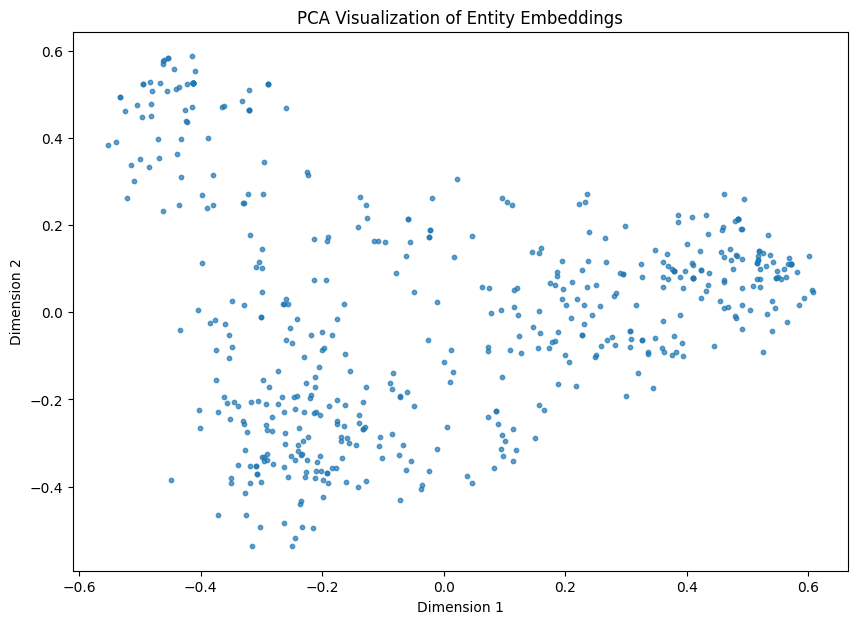

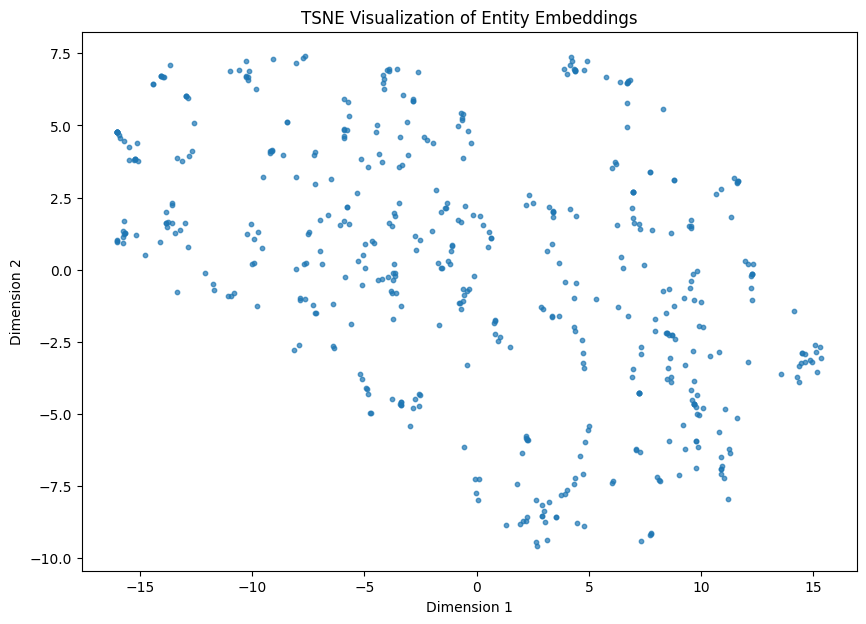

In [131]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings_df, method='pca', num_samples=500):
    """
    Visualize embeddings using PCA or t-SNE.
    """
    # Extract feature vectors and entity names
    features = embeddings_df.iloc[:, 1:].values  # Extract all columns except 'entity'
    entity_labels = embeddings_df['entity'].values
    
    # Reduce to 50 dimensions using PCA before t-SNE for efficiency
    if method == 'tsne':
        pca = PCA(n_components=50)
        features_reduced = pca.fit_transform(features)
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        features_2d = tsne.fit_transform(features_reduced[:num_samples])
        labels_2d = entity_labels[:num_samples]
    elif method == 'pca':
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features[:num_samples])
        labels_2d = entity_labels[:num_samples]
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # Plot the 2D embeddings
    plt.figure(figsize=(10, 7))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], s=10, alpha=0.7)
    # for i, label in enumerate(labels_2d):
    #     plt.text(features_2d[i, 0], features_2d[i, 1], label, fontsize=6, alpha=0.6)
    plt.title(f"{method.upper()} Visualization of Entity Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Visualize using PCA
visualize_embeddings(embeddings_df, method='pca', num_samples=500)

# Visualize using t-SNE
visualize_embeddings(embeddings_df, method='tsne', num_samples=500)


In [5]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00a 0:00:01


In [133]:
print(len(embeddings_df))

2034


In [134]:
print(len(triples))

32888


In [135]:
t_df=pd.DataFrame(triples)
t_df.to_csv('t.csv', index=False)

# 3.Graph Neural Network Model Design 

In [136]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx

# Map entities and relations to unique integer IDs
entity_to_id = {entity: idx for idx, entity in enumerate(embeddings_df['entity'])}
relation_to_id = {relation: idx for idx, relation in enumerate(triples['relation'].unique())}

# Track missing entities to handle cases where an entity in triples isn't in embeddings_df
missing_entities = set()

# Convert triples to edge list format with corresponding relation IDs
edges = []
edge_types = []

for _, row in triples.iterrows():
    # Check if head or tail entity is missing from entity_to_id
    head = row['head']
    tail = row['tail']
    relation = row['relation']
    
    # if head not in entity_to_id:
    #     missing_entities.add(head)
    #     continue
    # if tail not in entity_to_id:
    #     missing_entities.add(tail)
    #     continue
    
    head_id = entity_to_id[head]

    # print(head_id)
    tail_id = entity_to_id[tail]
    relation_id = relation_to_id[relation]
    
    edges.append((head_id, tail_id))
    edge_types.append(relation_id)

# Log missing entities if there are any
if missing_entities:
    print(f"Warning: {len(missing_entities)} entities in triples are missing from embeddings_df.")

# Prepare PyTorch tensors for edge list and relation types
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(edge_types, dtype=torch.long)

# Prepare initial node features from entity embeddings
node_features = torch.tensor(embeddings_df.iloc[:, 1:].values, dtype=torch.float)

# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_type=edge_type)
print("Data prepared for the GNN model.")

data


Data prepared for the GNN model.


Data(x=[2034, 384], edge_index=[2, 32888], edge_type=[32888])

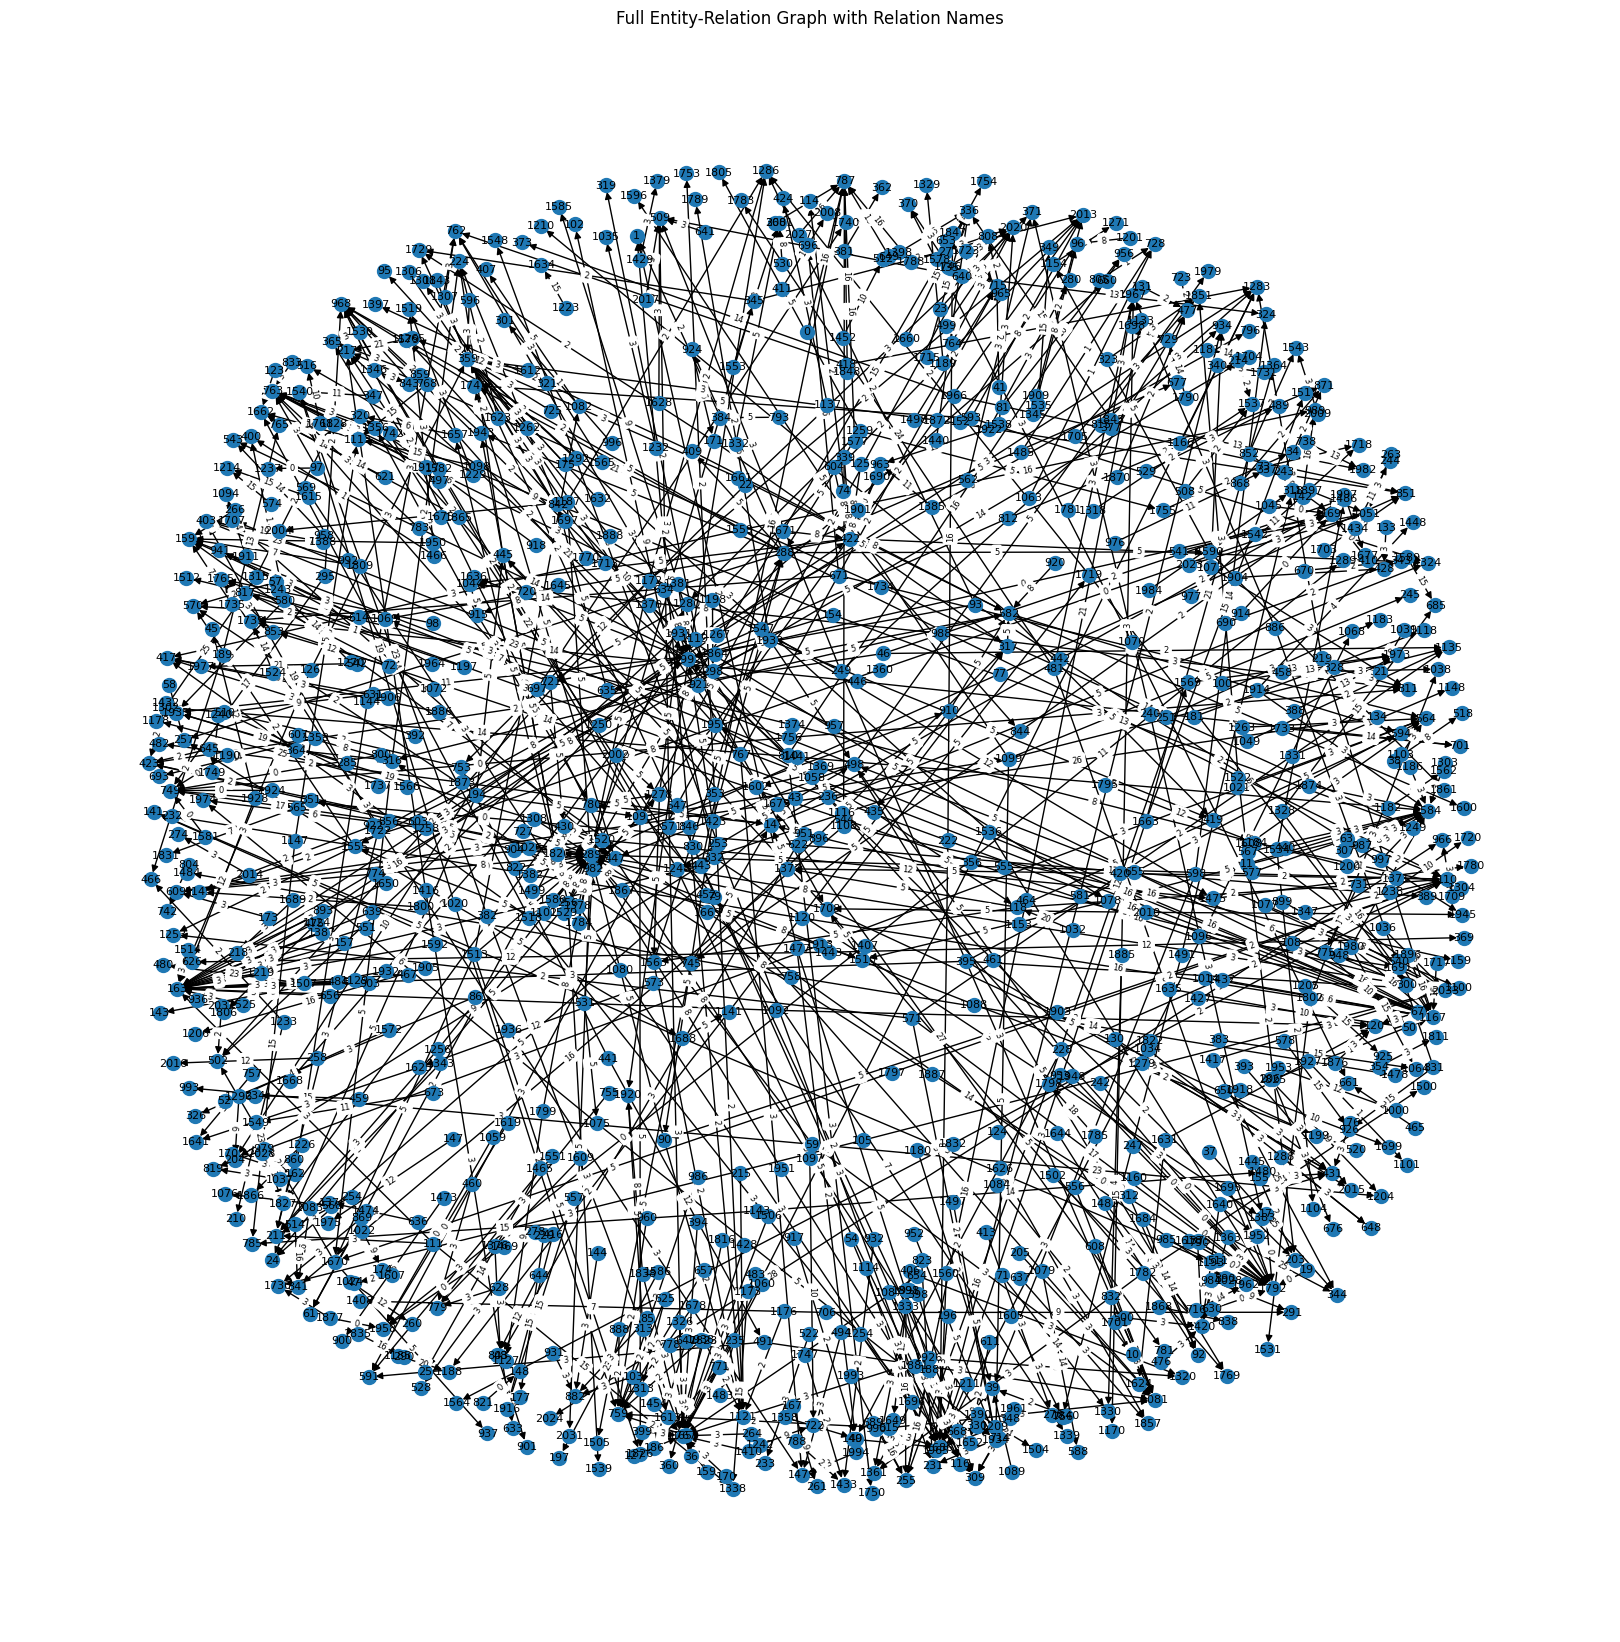

In [27]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import json

# Load relations.json to create a mapping from relation IDs to names
with open('/kaggle/working/codex/data/relations/en/relations.json', 'r') as f:
    relations = json.load(f)

def get_relation_label(relation_id):
    """Helper function to get the relation label given a relation ID."""
    return relations.get(str(relation_id), {}).get('label', str(relation_id))  # Use ID as fallback if label is missing

def visualize_full_entity_graph(data, max_nodes=1000, max_edges=2000, seed=42):
    """Visualize the full entity-relation graph, with limits for large graphs."""
    edge_index, edge_type = data.edge_index.cpu(), data.edge_type.cpu()
    G = nx.DiGraph()
    
    # Add edges with relation labels to the graph
    for i in range(min(edge_index.size(1), max_edges)):
        src, dest = edge_index[:, i].numpy()
        relation_id = edge_type[i].item()
        relation_label = get_relation_label(relation_id)
        
        # Add edge with relation label
        G.add_edge(src, dest, label=relation_label)
        
        # Limit nodes if the graph is too large
        if G.number_of_nodes() > max_nodes:
            break

    # Generate layout and visualize graph
    pos = nx.spring_layout(G, seed=seed, k=0.1)  # k-value adjusted for large graphs
    plt.figure(figsize=(16, 16))
    nx.draw(G, pos, with_labels=True, node_size=100, font_size=8, arrows=True)
    
    # Edge labels with relation names
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title("Full Entity-Relation Graph with Relation Names")
    plt.show()

# Visualize the entire graph with limitations on nodes and edges
visualize_full_entity_graph(data)


In [137]:
# import torch
# import torch.nn as nn
# from torch_geometric.nn import RGCNConv
# from torch_geometric.data import Data
# import torch.optim as optim

# class RGCNLinkPredictor(nn.Module):
#     def __init__(self, num_nodes, in_channels, hidden_channels, out_channels, num_relations):
#         super(RGCNLinkPredictor, self).__init__()
        
#         # Define R-GCN layers
#         self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
#         self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)
        
#         # Update fc layer to match doubled input size from concatenated embeddings
#         self.fc = nn.Linear(2 * out_channels, 1)
        
#     def forward(self, x, edge_index, edge_type):
#         # Apply first R-GCN layer
#         x = self.conv1(x, edge_index, edge_type)
#         x = torch.relu(x)
        
#         # Apply second R-GCN layer
#         x = self.conv2(x, edge_index, edge_type)
#         return x
    
#     def predict_links(self, x, edge_index):
#         # Compute scores for each edge in edge_index
#         src, dst = edge_index
#         edge_features = torch.cat([x[src], x[dst]], dim=1)  # Concatenate node embeddings
#         return torch.sigmoid(self.fc(edge_features)).squeeze()

# # Instantiate the model
# num_nodes = len(entity_to_id)
# num_relations = len(relation_to_id)
# in_channels = node_features.size(1)  # Using the dimension of initial node features
# hidden_channels = 64  # Hidden layer size
# out_channels = 32  # Output embedding size

# model = RGCNLinkPredictor(
#     num_nodes=num_nodes,
#     in_channels=in_channels,
#     hidden_channels=hidden_channels,
#     out_channels=out_channels,
#     num_relations=num_relations
# )

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Define optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# # Prepare PyTorch Geometric Data object with the adjacency matrix and LLM-based embeddings
# data = Data(x=node_features.to(device), edge_index=edge_index.to(device), edge_type=edge_type.to(device))

# # # Example of forward pass to test model setup
# # x = model(data.x, data.edge_index, data.edge_type)
# # print("Model output node embeddings shape:", x.shape)


In [138]:
# import torch
# import torch.nn.functional as F
# from torch_geometric.utils import negative_sampling
# from tqdm import tqdm

# # Check for GPU availability
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# data = data.to(device)

# # Define the training function
# def train(model, data, train_triples, optimizer, epochs=10):
#     model.train()
#     for epoch in range(epochs):
#         optimizer.zero_grad()
        
#         # Get node embeddings from the GNN
#         x = model(data.x, data.edge_index, data.edge_type)
        
#         # Prepare positive edges (from training triples)
#         pos_edge_index = torch.tensor(
#             [(entity_to_id[h], entity_to_id[t]) for h, _, t in train_triples.values if h in entity_to_id and t in entity_to_id],
#             dtype=torch.long
#         ).t().contiguous().to(device)
        
#         # Positive score for known links
#         pos_scores = model.predict_links(x, pos_edge_index)
        
#         # Negative sampling
#         neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes).to(device)
#         neg_scores = model.predict_links(x, neg_edge_index)
        
#         # Calculate binary cross-entropy loss
#         scores = torch.cat([pos_scores, neg_scores])
#         labels = torch.cat([torch.ones(pos_scores.size(0), device=device), torch.zeros(neg_scores.size(0), device=device)])
#         loss = F.binary_cross_entropy(scores, labels)
        
#         # Backpropagation and optimization step
#         loss.backward()
#         optimizer.step()
        
#         # Print progress every 10 epochs
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# # Initialize optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Train the model
# train(model, data, train_triples, optimizer)


### GNN Architecture Selection

In [6]:
import torch
import torch.nn as nn
from torch_geometric.nn import RGCNConv

class RGCNLinkPredictor(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_channels, out_channels, num_relations, num_layers=2):
        super(RGCNLinkPredictor, self).__init__()
        self.convs = nn.ModuleList()
        
        # Define RGCN layers
        self.convs.append(RGCNConv(in_channels, hidden_channels, num_relations))
        for _ in range(num_layers - 2):
            self.convs.append(RGCNConv(hidden_channels, hidden_channels, num_relations))
        self.convs.append(RGCNConv(hidden_channels, out_channels, num_relations))
        
        # Link prediction layer (score calculation)
        self.link_predictor = nn.Sequential(
            nn.Linear(2 * out_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, 1)
        )
    
    def forward(self, x, edge_index, edge_type):
        # Apply each RGCN layer
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
        
        return x  # Node embeddings

    def predict_links(self, x, edge_index):
        # Get embeddings for edge pairs
        head_embeddings = x[edge_index[0]]
        tail_embeddings = x[edge_index[1]]
        
        # Concatenate head and tail embeddings for prediction
        edge_features = torch.cat([head_embeddings, tail_embeddings], dim=1)
        scores = self.link_predictor(edge_features)
        return torch.sigmoid(scores).squeeze()


### Model Implementation

In [140]:
import torch
import torch.optim as optim
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, data, optimizer, epochs=10):
    model.train()
    
    # Move data to the GPU
    data = data.to(device)
    train_losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass to get node embeddings
        x = model(data.x, data.edge_index, data.edge_type)
        
        # Get positive edge predictions
        pos_edge_index = data.edge_index
        pos_scores = model.predict_links(x, pos_edge_index)
        
        # Sample negative edges for link prediction
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes)
        neg_scores = model.predict_links(x, neg_edge_index)
        
        # Combine positive and negative scores and compute loss
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones(pos_scores.size(0), device=device), 
                            torch.zeros(neg_scores.size(0), device=device)])
        
        loss = torch.nn.BCELoss()(scores, labels)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}")
            
    return train_losses


# Model and training setup
num_nodes = len(entity_to_id)
num_relations = len(relation_to_id)
model = RGCNLinkPredictor(num_nodes=num_nodes, in_channels=node_features.size(1),
                          hidden_channels=64, out_channels=32, num_relations=num_relations)

# Move model to GPU
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_losses = train(model, data, optimizer)



Epoch 0/10, Train Loss: 0.6921
Epoch 1/10, Train Loss: 0.6227
Epoch 2/10, Train Loss: 0.5445
Epoch 3/10, Train Loss: 0.4398
Epoch 4/10, Train Loss: 0.4213
Epoch 5/10, Train Loss: 0.3779
Epoch 6/10, Train Loss: 0.3468
Epoch 7/10, Train Loss: 0.3108
Epoch 8/10, Train Loss: 0.2961
Epoch 9/10, Train Loss: 0.2837


In [141]:
import torch
from torch_geometric.utils import negative_sampling
from tqdm import tqdm

def test(model, data, k_values=[1, 3, 10]):
    model.eval()
    
    # Move data to the GPU
    data = data.to(device)
    test_losses = []
    mrr = 0.0
    hits_at_k = {k: 0 for k in k_values}
    num_positive_edges = data.edge_index.size(1)
    
    with torch.no_grad():
        # Get node embeddings
        x = model(data.x, data.edge_index, data.edge_type)
        
        # Get positive edge predictions
        pos_edge_index = data.edge_index
        pos_scores = model.predict_links(x, pos_edge_index)
        
        # Sample negative edges
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes).to(device)
        neg_scores = model.predict_links(x, neg_edge_index)
        
        # Combine positive and negative scores and compute loss
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones(pos_scores.size(0), device=device), 
                            torch.zeros(neg_scores.size(0), device=device)])
        
        loss = torch.nn.BCELoss()(scores, labels)
        test_losses.append(loss.item())
        
        # Initialize progress bar
        for i in tqdm(range(num_positive_edges), desc="Evaluating", unit="edge"):
            true_score = pos_scores[i].item()
            # Ensure true_score is moved to the same device as neg_scores
            true_score_tensor = torch.tensor([true_score], device=device)
            all_scores = torch.cat([true_score_tensor, neg_scores]).tolist()
            all_scores.sort(reverse=True)
            
            # Find the rank of the true score
            rank = all_scores.index(true_score) + 1
            mrr += 1.0 / rank
            
            # Calculate Hits@k
            for k in k_values:
                if rank <= k:
                    hits_at_k[k] += 1
            
            # # Print top 10 tails for the current edge
            # if i < 10:  # Print for the first 10 edges as an example
            #     top10_tails = [tail_id for _, tail_id in sorted(zip(all_scores, range(data.num_nodes)), reverse=True)[:10]]
            #     print(f"Top 10 predicted tails for edge {i + 1}: {top10_tails}")

    # Normalize MRR and Hits@k
    mrr /= num_positive_edges
    hits_at_k = {k: hits / num_positive_edges for k, hits in hits_at_k.items()}
    
    # Print results
    print(f"Test Loss: {sum(test_losses) / len(test_losses):.4f}")
    print(f"MRR: {mrr:.4f}")
    for k in k_values:
        print(f"Hits@{k}: {hits_at_k[k]:.4f}")
    
    return test_losses, mrr, hits_at_k

# Test the model after training
test_losses, mrr, hits_at_k = test(model, data)


Evaluating:   0%|          | 0/32888 [00:00<?, ?edge/s]

Top 10 predicted tails for edge 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Evaluating: 100%|██████████| 32888/32888 [04:00<00:00, 136.65edge/s]

Test Loss: 0.2712
MRR: 0.0177
Hits@1: 0.0037
Hits@3: 0.0201
Hits@10: 0.0490


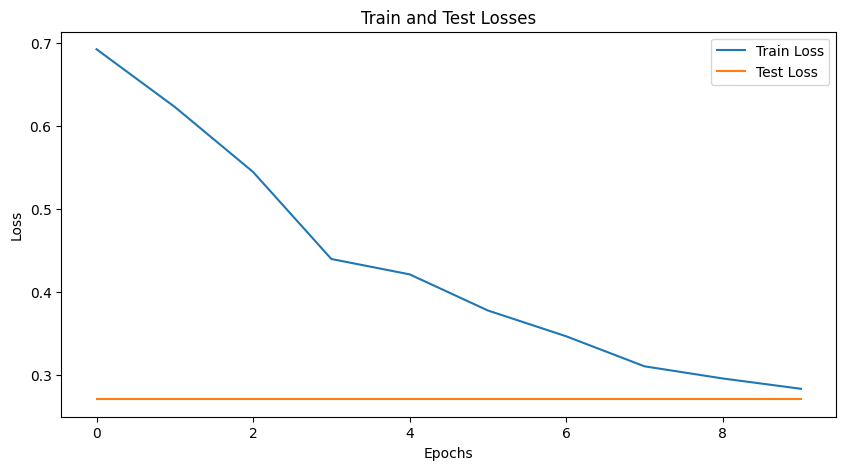

In [142]:
# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot([0, len(train_losses)-1], [test_losses[0]]*2, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Losses")
plt.legend()
plt.show()

### Random Initialization

In [19]:
import numpy as np

def get_random_embeddings(entities, embed_dim=348):
    entity_embeddings = {entity: np.random.rand(embed_dim) for entity in entities}
    print(f"Generated random embeddings for {len(entity_embeddings)} entities")
    return entity_embeddings

# Extract unique entities from triples and generate random embeddings
unique_entities_r = set(triples["head"]).union(set(triples["tail"]))
entity_embeddings_r = get_random_embeddings(unique_entities_r)

Generated random embeddings for 2034 entities


In [20]:
# Convert the entity embeddings into a DataFrame for easy handling
embeddings_df_r = pd.DataFrame.from_dict(entity_embeddings_r, orient='index')
embeddings_df_r.index.name = 'entity'
embeddings_df_r.reset_index(inplace=True)

# Save the embeddings for future use (optional)
embeddings_df_r.to_csv('entity_embeddings_random.csv', index=False)
print("Embeddings stored successfully.")


Embeddings stored successfully.


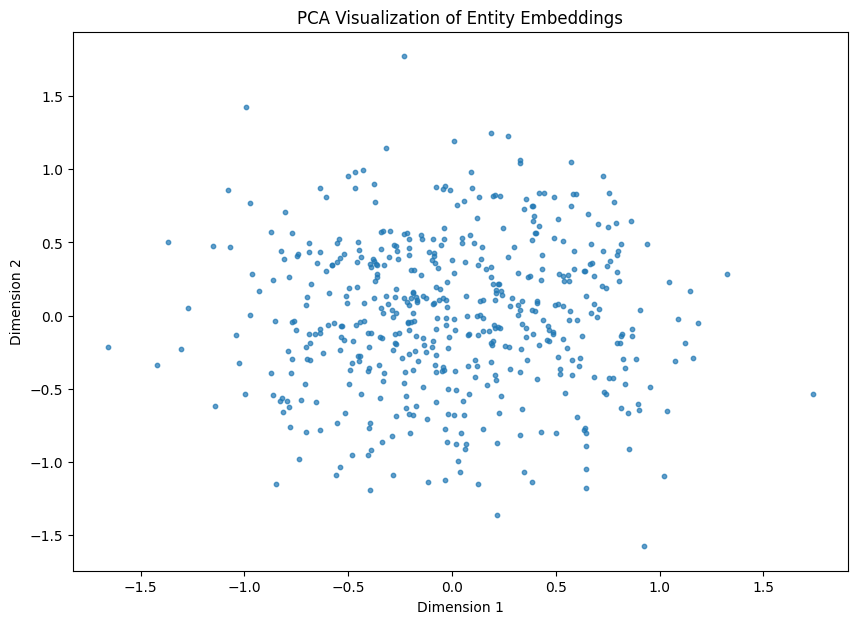

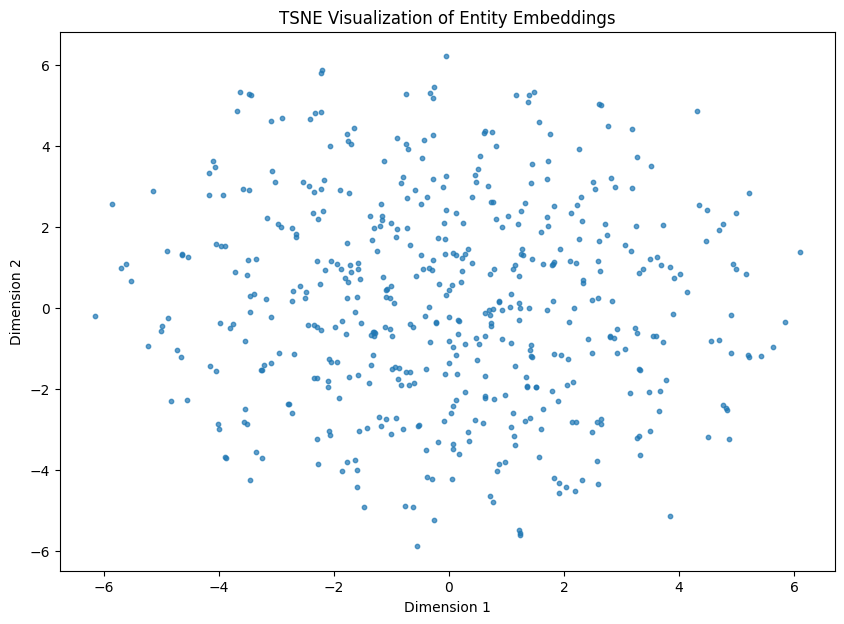

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings_df, method='pca', num_samples=500):
    """
    Visualize embeddings using PCA or t-SNE.
    """
    # Extract feature vectors and entity names
    features = embeddings_df.iloc[:, 1:].values  # Extract all columns except 'entity'
    entity_labels = embeddings_df['entity'].values
    
    # Reduce to 50 dimensions using PCA before t-SNE for efficiency
    if method == 'tsne':
        pca = PCA(n_components=50)
        features_reduced = pca.fit_transform(features)
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
        features_2d = tsne.fit_transform(features_reduced[:num_samples])
        labels_2d = entity_labels[:num_samples]
    elif method == 'pca':
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features[:num_samples])
        labels_2d = entity_labels[:num_samples]
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # Plot the 2D embeddings
    plt.figure(figsize=(10, 7))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], s=10, alpha=0.7)
    # for i, label in enumerate(labels_2d):
    #     plt.text(features_2d[i, 0], features_2d[i, 1], label, fontsize=6, alpha=0.6)
    plt.title(f"{method.upper()} Visualization of Entity Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Visualize using PCA
visualize_embeddings(embeddings_df_r, method='pca', num_samples=500)

# Visualize using t-SNE
visualize_embeddings(embeddings_df_r, method='tsne', num_samples=500)


In [22]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx

# Map entities and relations to unique integer IDs
entity_to_id = {entity: idx for idx, entity in enumerate(embeddings_df_r['entity'])}
relation_to_id = {relation: idx for idx, relation in enumerate(triples['relation'].unique())}

# Track missing entities to handle cases where an entity in triples isn't in embeddings_df
missing_entities = set()

# Convert triples to edge list format with corresponding relation IDs
edges = []
edge_types = []

for _, row in triples.iterrows():
    # Check if head or tail entity is missing from entity_to_id
    head = row['head']
    tail = row['tail']
    relation = row['relation']
    
    # if head not in entity_to_id:
    #     missing_entities.add(head)
    #     continue
    # if tail not in entity_to_id:
    #     missing_entities.add(tail)
    #     continue
    
    head_id = entity_to_id[head]

    # print(head_id)
    tail_id = entity_to_id[tail]
    relation_id = relation_to_id[relation]
    
    edges.append((head_id, tail_id))
    edge_types.append(relation_id)

# Log missing entities if there are any
if missing_entities:
    print(f"Warning: {len(missing_entities)} entities in triples are missing from embeddings_df.")

# Prepare PyTorch tensors for edge list and relation types
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(edge_types, dtype=torch.long)

# Prepare initial node features from entity embeddings
node_features = torch.tensor(embeddings_df_r.iloc[:, 1:].values, dtype=torch.float)

# Create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_type=edge_type)
print("Data prepared for the GNN model.")

data


Data prepared for the GNN model.


Data(x=[2034, 348], edge_index=[2, 32888], edge_type=[32888])

In [24]:
import torch
import torch.optim as optim
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, data, optimizer, epochs=10):
    model.train()
    
    # Move data to the GPU
    data = data.to(device)
    train_losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass to get node embeddings
        x = model(data.x, data.edge_index, data.edge_type)
        
        # Get positive edge predictions
        pos_edge_index = data.edge_index
        pos_scores = model.predict_links(x, pos_edge_index)
        
        # Sample negative edges for link prediction
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes)
        neg_scores = model.predict_links(x, neg_edge_index)
        
        # Combine positive and negative scores and compute loss
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones(pos_scores.size(0), device=device), 
                            torch.zeros(neg_scores.size(0), device=device)])
        
        loss = torch.nn.BCELoss()(scores, labels)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}")
            
    return train_losses


# Model and training setup
num_nodes = len(entity_to_id)
num_relations = len(relation_to_id)
model = RGCNLinkPredictor(num_nodes=num_nodes, in_channels=node_features.size(1),
                          hidden_channels=64, out_channels=32, num_relations=num_relations)

# Move model to GPU
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_losses = train(model, data, optimizer)



Epoch 1/10, Train Loss: 0.7161
Epoch 2/10, Train Loss: 0.9357
Epoch 3/10, Train Loss: 2.1233
Epoch 4/10, Train Loss: 0.4699
Epoch 5/10, Train Loss: 0.5120
Epoch 6/10, Train Loss: 0.4371
Epoch 7/10, Train Loss: 0.3715
Epoch 8/10, Train Loss: 0.3500
Epoch 9/10, Train Loss: 0.3130
Epoch 10/10, Train Loss: 0.3121


In [25]:
import torch
from torch_geometric.utils import negative_sampling
from tqdm import tqdm

def test(model, data, k_values=[1, 3, 10]):
    model.eval()
    
    # Move data to the GPU
    data = data.to(device)
    test_losses = []
    mrr = 0.0
    hits_at_k = {k: 0 for k in k_values}
    num_positive_edges = data.edge_index.size(1)
    
    with torch.no_grad():
        # Get node embeddings
        x = model(data.x, data.edge_index, data.edge_type)
        
        # Get positive edge predictions
        pos_edge_index = data.edge_index
        pos_scores = model.predict_links(x, pos_edge_index)
        
        # Sample negative edges
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes).to(device)
        neg_scores = model.predict_links(x, neg_edge_index)
        
        # Combine positive and negative scores and compute loss
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones(pos_scores.size(0), device=device), 
                            torch.zeros(neg_scores.size(0), device=device)])
        
        loss = torch.nn.BCELoss()(scores, labels)
        test_losses.append(loss.item())
        
        # Initialize progress bar
        for i in tqdm(range(num_positive_edges), desc="Evaluating", unit="edge"):
            true_score = pos_scores[i].item()
            # Ensure true_score is moved to the same device as neg_scores
            true_score_tensor = torch.tensor([true_score], device=device)
            all_scores = torch.cat([true_score_tensor, neg_scores]).tolist()
            all_scores.sort(reverse=True)
            
            # Find the rank of the true score
            rank = all_scores.index(true_score) + 1
            mrr += 1.0 / rank
            
            # Calculate Hits@k
            for k in k_values:
                if rank <= k:
                    hits_at_k[k] += 1
            
            # Print top 10 tails for the current edge
            if i < 10:  # Print for the first 10 edges as an example
                top10_tails = [tail_id for _, tail_id in sorted(zip(all_scores, range(data.num_nodes)), reverse=True)[:10]]
                print(f"Top 10 predicted tails for edge {i + 1}: {top10_tails}")

    # Normalize MRR and Hits@k
    mrr /= num_positive_edges
    hits_at_k = {k: hits / num_positive_edges for k, hits in hits_at_k.items()}
    
    # Print results
    print(f"Test Loss: {sum(test_losses) / len(test_losses):.4f}")
    print(f"MRR: {mrr:.4f}")
    for k in k_values:
        print(f"Hits@{k}: {hits_at_k[k]:.4f}")
    
    return test_losses, mrr, hits_at_k

# Test the model after training
test_losses, mrr, hits_at_k = test(model, data)


Evaluating:   0%|          | 24/32888 [00:00<04:35, 119.10edge/s]

Top 10 predicted tails for edge 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Top 10 predicted tails for edge 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Evaluating: 100%|██████████| 32888/32888 [04:31<00:00, 121.05edge/s]

Test Loss: 0.3115
MRR: 0.0108
Hits@1: 0.0018
Hits@3: 0.0115
Hits@10: 0.0206


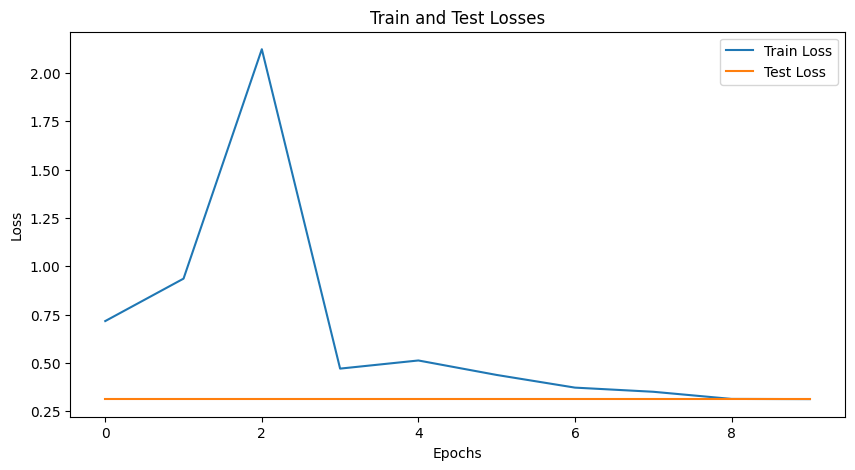

In [26]:
# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot([0, len(train_losses)-1], [test_losses[0]]*2, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Losses")
plt.legend()
plt.show()

# 4.Knowledge Base Completion Task

### Training and Testing Setup

In [143]:
from sklearn.model_selection import train_test_split

# Assume triples DataFrame with columns: "head", "relation", "tail"
train_triples, test_triples = train_test_split(triples, test_size=0.2, random_state=42)
val_triples, test_triples = train_test_split(test_triples, test_size=0.5, random_state=42)

print(f"Training triples: {len(train_triples)}, Validation triples: {len(val_triples)}, Test triples: {len(test_triples)}")


Training triples: 26310, Validation triples: 3289, Test triples: 3289


In [144]:
import torch
import torch.optim as optim
from torch_geometric.utils import negative_sampling
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model training function
def train_kg_completion(model, data, train_triples, optimizer, epochs=10):
    model.train()
    data = data.to(device)  # Move data to GPU
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Get embeddings from the GNN
        x = model(data.x, data.edge_index, data.edge_type)
        
        # Positive edges from training triples
        pos_edge_list = [
            (entity_to_id[h], entity_to_id[t]) 
            for h, _, t in train_triples.values 
            if h in entity_to_id and t in entity_to_id
        ]
        
        pos_edge_index = torch.tensor(pos_edge_list, dtype=torch.long).t().contiguous().to(device)
        pos_scores = model.predict_links(x, pos_edge_index)
        
        # Negative sampling for link prediction
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes).to(device)
        neg_scores = model.predict_links(x, neg_edge_index)
        
        # Combine positive and negative scores for loss computation
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([
            torch.ones(pos_scores.size(0), device=device), 
            torch.zeros(neg_scores.size(0), device=device)
        ])
        loss = torch.nn.BCELoss()(scores, labels)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Model, optimizer, and dataset setup
num_nodes = len(entity_to_id)
num_relations = len(relation_to_id)
model = RGCNLinkPredictor(num_nodes=num_nodes, in_channels=node_features.size(1),
                          hidden_channels=64, out_channels=32, num_relations=num_relations).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_kg_completion(model, data, train_triples, optimizer)

Epoch 1/10, Loss: 0.6976
Epoch 2/10, Loss: 0.6338
Epoch 3/10, Loss: 0.5458
Epoch 4/10, Loss: 0.4521
Epoch 5/10, Loss: 0.3969
Epoch 6/10, Loss: 0.3739
Epoch 7/10, Loss: 0.3418
Epoch 8/10, Loss: 0.3048
Epoch 9/10, Loss: 0.2835
Epoch 10/10, Loss: 0.2715


### Evaluation and Metrics

In [146]:
import torch
from tqdm import tqdm

def evaluate_kg_completion(model, data, test_triples, k_values=[1,3,10]):
    model.eval()
    data = data.to(device)
    
    mrr = 0.0
    hits_at_k = {k: 0 for k in k_values}
    missing_entities = set()

    with torch.no_grad():
        x = model(data.x, data.edge_index, data.edge_type)
        
        for i, (_, row) in enumerate(tqdm(test_triples.iterrows(), total=len(test_triples))):
            if row['head'] not in entity_to_id or row['tail'] not in entity_to_id:
                missing_entities.update([row['head'], row['tail']])
                continue
            
            head_id = entity_to_id[row['head']]
            relation = relation_to_id[row['relation']]
            true_tail_id = entity_to_id[row['tail']]
            
            head_id = torch.tensor([head_id], device=device)
            true_tail_id = torch.tensor([true_tail_id], device=device)
            
            scores = []
            for tail_id in range(data.num_nodes):
                tail_tensor = torch.tensor([[head_id.item()], [tail_id]], device=device)
                score = model.predict_links(x, tail_tensor)
                scores.append((score.item(), tail_id))
            
            scores.sort(reverse=True, key=lambda x: x[0])
            
            rank = [tail_id for _, tail_id in scores].index(true_tail_id.item()) + 1
            
            mrr += 1 / rank
            for k in k_values:
                if rank <= k:
                    hits_at_k[k] += 1

            # Debugging Output
            if i < 5:  # Print details for the first few test triples
                print(f"Test Triple {i + 1}")
                print(f"Head ID: {head_id.item()}, True Tail ID: {true_tail_id.item()}")
                print("Top predictions (tail ID, score):", scores[:5])
                print(f"True tail rank: {rank}")

        num_triples = len(test_triples) - len(missing_entities)
        mrr /= num_triples
        hits_at_k = {k: hits / num_triples for k, hits in hits_at_k.items()}
        
        print(f"MRR: {mrr:.4f}")
        for k in k_values:
            print(f"Hits@{k}: {hits_at_k[k]:.4f}")
        
        if missing_entities:
            print(f"Warning: {len(missing_entities)} entities in test_triples are missing in entity_to_id.")

# Evaluate the model
evaluate_kg_completion(model, data, test_triples)

  0%|          | 1/3289 [00:00<30:57,  1.77it/s]

Test Triple 1
Head ID: 1496, True Tail ID: 1460
Top predictions (tail ID, score): [(0.9858890175819397, 773), (0.983084499835968, 1420), (0.9805656671524048, 0), (0.9801473617553711, 1366), (0.9784098267555237, 446)]
True tail rank: 65


  0%|          | 2/3289 [00:01<31:05,  1.76it/s]

Test Triple 2
Head ID: 1692, True Tail ID: 1364
Top predictions (tail ID, score): [(0.9999150037765503, 773), (0.9998030066490173, 1420), (0.999775230884552, 284), (0.9992212057113647, 1639), (0.9987930059432983, 1470)]
True tail rank: 166


  0%|          | 3/3289 [00:01<31:23,  1.74it/s]

Test Triple 3
Head ID: 1859, True Tail ID: 947
Top predictions (tail ID, score): [(0.9871609210968018, 773), (0.9845447540283203, 1420), (0.9809904098510742, 1366), (0.980602502822876, 0), (0.9792168736457825, 446)]
True tail rank: 18


  0%|          | 4/3289 [00:02<32:06,  1.70it/s]

Test Triple 4
Head ID: 1303, True Tail ID: 1679
Top predictions (tail ID, score): [(0.9938308000564575, 773), (0.9924978613853455, 1420), (0.9839896559715271, 1366), (0.9826667308807373, 446), (0.981177806854248, 1845)]
True tail rank: 245


  0%|          | 5/3289 [00:02<31:44,  1.72it/s]

Test Triple 5
Head ID: 768, True Tail ID: 1612
Top predictions (tail ID, score): [(0.9921179413795471, 773), (0.9904522895812988, 1420), (0.9837672710418701, 1366), (0.983230471611023, 446), (0.9822705388069153, 1845)]
True tail rank: 48


100%|██████████| 3289/3289 [31:27<00:00,  1.74it/s]

MRR: 0.0535
Hits@1: 0.0246
Hits@3: 0.0429
Hits@10: 0.0903


# Hyperparameter Tuning

In [147]:
class RGCNLinkPredictor(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_channels, out_channels, num_relations, num_layers=2, dropout=0.0):
        super(RGCNLinkPredictor, self).__init__()
        self.convs = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        
        # Define RGCN layers
        self.convs.append(RGCNConv(in_channels, hidden_channels, num_relations))
        for _ in range(num_layers - 2):
            self.convs.append(RGCNConv(hidden_channels, hidden_channels, num_relations))
        self.convs.append(RGCNConv(hidden_channels, out_channels, num_relations))
        
        # Link prediction layer (score calculation)
        self.link_predictor = nn.Sequential(
            nn.Linear(2 * out_channels, out_channels),
            nn.ReLU(),
            self.dropout,
            nn.Linear(out_channels, 1)
        )
    
    def forward(self, x, edge_index, edge_type):
        # Apply each RGCN layer with dropout
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            x = torch.relu(x)
            x = self.dropout(x)
        
        return x  # Node embeddings

    def predict_links(self, x, edge_index):
        # Get embeddings for edge pairs
        head_embeddings = x[edge_index[0]]
        tail_embeddings = x[edge_index[1]]
        
        # Concatenate head and tail embeddings for prediction
        edge_features = torch.cat([head_embeddings, tail_embeddings], dim=1)
        scores = self.link_predictor(edge_features)
        return torch.sigmoid(scores).squeeze()


In [148]:
import torch
import torch.optim as optim
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, data, optimizer, epochs=10):
    model.train()
    
    # Move data to the GPU
    data = data.to(device)
    train_losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass to get node embeddings
        x = model(data.x, data.edge_index, data.edge_type)
        
        # Get positive edge predictions
        pos_edge_index = data.edge_index
        pos_scores = model.predict_links(x, pos_edge_index)
        
        # Sample negative edges for link prediction
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes)
        neg_scores = model.predict_links(x, neg_edge_index)
        
        # Combine positive and negative scores and compute loss
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones(pos_scores.size(0), device=device), 
                            torch.zeros(neg_scores.size(0), device=device)])
        
        loss = torch.nn.BCELoss()(scores, labels)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}")
            
    return train_losses


def test(model, data):
    model.eval()
    
    # Move data to the GPU
    data = data.to(device)
    test_losses = []
    
    with torch.no_grad():
        x = model(data.x, data.edge_index, data.edge_type)
        
        # Get positive edge predictions
        pos_edge_index = data.edge_index
        pos_scores = model.predict_links(x, pos_edge_index)
        
        # Sample negative edges for link prediction
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes)
        neg_scores = model.predict_links(x, neg_edge_index)
        
        # Combine positive and negative scores and compute loss
        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones(pos_scores.size(0), device=device), 
                            torch.zeros(neg_scores.size(0), device=device)])
        
        loss = torch.nn.BCELoss()(scores, labels)
        test_losses.append(loss.item())
        print("Test Loss",test_losses)
        
    return test_losses

In [149]:
import matplotlib.pyplot as plt
import itertools

# Define hyperparameter ranges
learning_rates = [0.001, 0.005]
num_layers_list = [2,4]
hidden_dims = [128]
dropouts = [0.0, 0.2]

# Function to train and evaluate model with specified hyperparameters
def run_experiment(lr, num_layers, hidden_dim, dropout):
    model = RGCNLinkPredictor(num_nodes=num_nodes, in_channels=node_features.size(1),
                              hidden_channels=hidden_dim, out_channels=32, num_relations=num_relations,
                              num_layers=num_layers, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    train_losses = train(model, data, optimizer, epochs=10)
    
    # Testing the model to get test losses and other metrics
    test_losses= test(model, data)

    print(test_losses)
    
    return train_losses, test_losses

# Run experiments for all combinations of hyperparameters
results = []
for lr, num_layers, hidden_dim, dropout in itertools.product(learning_rates, num_layers_list, hidden_dims, dropouts):
    print(f"Testing configuration: lr={lr}, layers={num_layers}, hidden_dim={hidden_dim}, dropout={dropout}")
    train_losses, test_losses = run_experiment(lr, num_layers, hidden_dim, dropout)
    results.append({
        'lr': lr,
        'num_layers': num_layers,
        'hidden_dim': hidden_dim,
        'dropout': dropout,
        'train_losses': train_losses,
        'test_losses': test_losses
    })


Testing configuration: lr=0.001, layers=2, hidden_dim=128, dropout=0.0
Test Loss [0.6143075227737427]
[0.6143075227737427]
Testing configuration: lr=0.001, layers=2, hidden_dim=128, dropout=0.2
Test Loss [0.6141747236251831]
[0.6141747236251831]
Testing configuration: lr=0.001, layers=4, hidden_dim=128, dropout=0.0
Test Loss [0.5870645046234131]
[0.5870645046234131]
Testing configuration: lr=0.001, layers=4, hidden_dim=128, dropout=0.2
Test Loss [0.6010721921920776]
[0.6010721921920776]
Testing configuration: lr=0.005, layers=2, hidden_dim=128, dropout=0.0
Test Loss [0.37693750858306885]
[0.37693750858306885]
Testing configuration: lr=0.005, layers=2, hidden_dim=128, dropout=0.2
Test Loss [0.3671841025352478]
[0.3671841025352478]
Testing configuration: lr=0.005, layers=4, hidden_dim=128, dropout=0.0
Test Loss [0.2940332591533661]
[0.2940332591533661]
Testing configuration: lr=0.005, layers=4, hidden_dim=128, dropout=0.2
Test Loss [0.29782211780548096]
[0.29782211780548096]


In [150]:
# print(results['test_losses'])

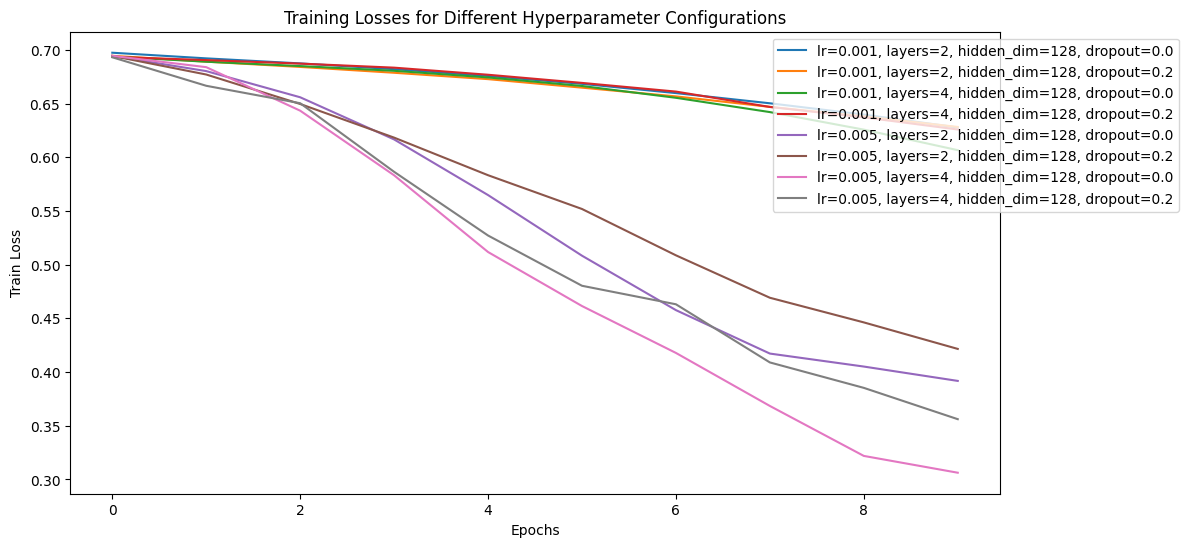

In [151]:
# Plot all training losses in one graph
plt.figure(figsize=(12, 6))
for result in results:
    label = f"lr={result['lr']}, layers={result['num_layers']}, hidden_dim={result['hidden_dim']}, dropout={result['dropout']}"
    plt.plot(result['train_losses'], label=label)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Training Losses for Different Hyperparameter Configurations")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))  # Adjust legend position for readability
plt.show()
